In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import numpy as np
import random
import sklearn

In [ ]:
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
current_path = os.path.abspath('.')
label_encoder = LabelEncoder()
fi=os.path.abspath('../../data/cohortedData.csv')
data = pd.read_csv(fi)
data.fillna(0, inplace=True)

In [3]:
data.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'race', 'language', 'admElective',
       'insurance', 'age', 'gender', 'anchor_year_group', 'sepsis3',
       'hadInsulinDayOne', 'hadMeasurmentDayOne', 'SOFA', 'respiration',
       'coagulation', 'liver', 'cardiovascular', 'cns', 'renal',
       'diabetes_without_cc', 'diabetes_with_cc', 'charlson_comorbidity_index',
       'pneumonia', 'uti', 'biliary', 'skin', 'hypertension_present',
       'heart_failure_present', 'copd_present', 'asthma_present',
       'cad_present', 'ckd_stages', 'diabetes_types', 'connective_disease',
       'dka_present', 'methylprednisolone_equivalent_total',
       'methylprednisolone_equivalent_normalized_by_icu_los', 'hadSteroid',
       'major_surgery', 'race_group', 'lactate_max', 'ph_min', 'po2_min',
       'spo2_mean', 'resp_rate_mean', 'heart_rate_mean', 'temperature_mean',
       'mbp_mean', 'total_insulin_amount', 'totalinsulin_perLOS',

In [4]:
data['major_surgery'].unique()

array([0, 1])

In [5]:
data['admElective'] = label_encoder.fit_transform(data['admElective'])
data['hadMeasurmentDayOne'] = label_encoder.fit_transform(data['hadMeasurmentDayOne'])


niceColumns=['isMale','english_Proficent','copd_present','diabetes','asthma_present','admElective','hadSteroid','major_surgery'] #, lab values (yes/no, if taken), 'hadSteroid','major_surgery'
#niceColumns=["uti", "biliary", "skin", 'hypertension_present','heart_failure_present','copd_present','cad_present','diabetes','isMale','ckd_stages','hadInsulinDayOne','english_Proficent']

categorical_vars = ['insurance','anchor_year_group','race_group']
dummy_vars = pd.get_dummies(data[categorical_vars])
dummy_vars = dummy_vars.drop(columns=['race_group_White'])
dummy_vars = dummy_vars.drop(columns=['anchor_year_group_2008 - 2010'])
dummy_vars = dummy_vars.drop(columns=['insurance_Other'])


data = pd.concat([data, dummy_vars], axis=1)


continuous_vars = ['age','charlson_comorbidity_index','SOFA']
#,'sofa','cardiovascular','cns','coagulation','liver','renal','respiration'
independent = data[continuous_vars + list(dummy_vars.columns)+niceColumns]

dependent = data['hadMeasurmentDayOne']

In [6]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(independent, dependent, test_size=0.25, random_state=16)

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

# Step 2: Get the logistic regression coefficients
coefficients = log_reg.coef_[0]

# Step 3: Calculate odds ratios by exponentiating the coefficients
odds_ratios = np.exp(coefficients)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from scipy.linalg import inv


coef = log_reg.coef_[0]
intercept = log_reg.intercept_[0]

# Calculate the variance-covariance matrix
# Use the Hessian formula for logistic regression: H = X.T * W * X
# where W is a diagonal matrix of weights, calculated as w_i = p_i * (1 - p_i)
pred_proba = log_reg.predict_proba(X_train)[:, 1]
W = np.diag(pred_proba * (1 - pred_proba))
X_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train])  # add a column for the intercept
Hessian = X_design.T.dot(W).dot(X_design)
cov_matrix = inv(Hessian)

# Extract the standard errors
std_errors = np.sqrt(np.diag(cov_matrix))
conf_intervals = [(coef - 1.96 * se, coef + 1.96 * se) for coef, se in zip(np.append(intercept, coef), std_errors)]

In [30]:
from scipy.stats import norm

coefs = log_reg.coef_[0]
std_errors = np.sqrt(np.diag(np.linalg.inv(np.dot(X_train.T, X_train))))

# Define desired confidence level (e.g., 95% confidence interval)
confidence_level = 0.95

# Calculate z-score for the critical value
critical_value = norm.ppf((1 + confidence_level) / 2)

# Calculate lower and upper bounds of the confidence interval
lower_bounds =  np.exp(coefs - (critical_value * std_errors))
upper_bounds = np.exp(coefs + (critical_value * std_errors))
variable_names=independent.columns
result=pd.DataFrame({'Variable': variable_names, 'Odds Ratio': odds_ratios,'low': lower_bounds, 'up':upper_bounds})

interceptRow={'Variable':"Intercept",'Odds Ratio':intercept,'low':conf_intervals[0][0],'up':conf_intervals[0][1]}

result.loc[-1] = interceptRow
result.index = result.index + 1
result = result.sort_index()
print(result)

                         Variable  Odds Ratio       low        up
0                       Intercept    1.517835  1.164275  1.871396
1                             age    0.995118  0.994223  0.996015
2      charlson_comorbidity_index    1.060984  1.054318  1.067692
3                            SOFA    1.086313  1.081793  1.090852
4              insurance_Medicaid    0.897569  0.846225  0.952027
5              insurance_Medicare    1.013357  0.980745  1.047055
6   anchor_year_group_2011 - 2013    0.954278  0.920052  0.989778
7   anchor_year_group_2014 - 2016    1.034750  0.994879  1.076219
8   anchor_year_group_2017 - 2019    0.896448  0.854141  0.940851
9                race_group_Asian    0.926414  0.852144  1.007157
10               race_group_Black    0.967586  0.924892  1.012251
11            race_group_Hispanic    1.346248  1.250140  1.449744
12                         isMale    0.997211  0.968887  1.026363
13              english_Proficent    1.134801  1.085442  1.186405
14        

In [31]:
data['hadMeasurmentDayOne'].describe()

count    24927.000000
mean         0.912866
std          0.282038
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: hadMeasurmentDayOne, dtype: float64

In [45]:
result.head()
result['Variable'] = result['Variable'].replace('insurance_Medicaid', 'Medicaid')
result['Variable'] = result['Variable'].replace('insurance_Medicare', 'Medicare')
result['Variable'] = result['Variable'].replace('charlson_comorbidity_index', 'Charlson comorbidity index')
result['Variable'] = result['Variable'].replace('race_group_Asian', 'Asian')
result['Variable'] = result['Variable'].replace('race_group_Black', 'Black')
result['Variable'] = result['Variable'].replace('race_group_Hispanic', 'Hispanic')
result['Variable'] = result['Variable'].replace('major_surgery', 'Major Surgery')
result['Variable'] = result['Variable'].replace('anchor_year_group_2017 - 2019', '2017-2019')
result['Variable'] = result['Variable'].replace('anchor_year_group_2014 - 2016', '2014-2016')
result['Variable'] = result['Variable'].replace('anchor_year_group_2011 - 2013', '2011-2013')
result['Variable'] = result['Variable'].replace('english_Proficent', 'English proficient')
result['Variable'] = result['Variable'].replace('age', 'Age')
result['Variable'] = result['Variable'].replace('hadSteroid', 'Had steroid')
result['Variable'] = result['Variable'].replace('admElective', 'Elective admission')
result['Variable'] = result['Variable'].replace('asthma_present', 'Asthma present')
result['Variable'] = result['Variable'].replace('diabetes', 'Diabetes present')
result['Variable'] = result['Variable'].replace('copd_present', 'COPD present')
result['Variable'] = result['Variable'].replace('isMale', 'Sex Male')

In [ ]:
from google.colab import files

result.to_excel('logregSum.xlsx',index=False)
files.download('logregSum.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

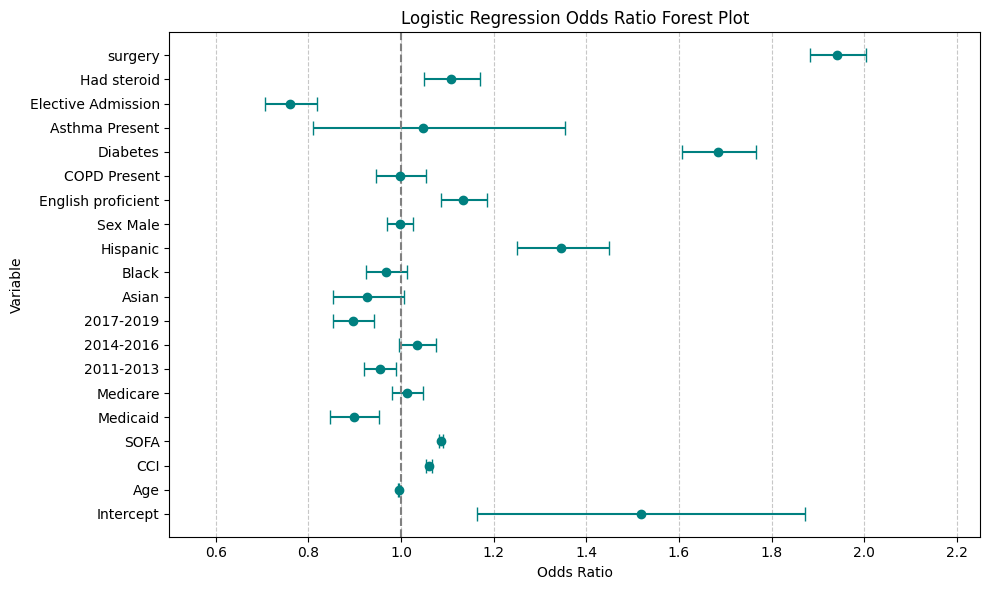

In [44]:
import pandas as pd
import matplotlib.pyplot as plt




# Create the forest plot
plt.figure(figsize=(10, len(result) * 0.3))  # Adjust the figure size based on the number of variables
plt.errorbar(result['Odds Ratio'], result['Variable'], xerr=[result['Odds Ratio'] - result['low'], result['up'] - result['Odds Ratio']],
             fmt='o', color='teal', capsize=5)
plt.axvline(x=1.0, color='gray', linestyle='--')
plt.xlabel('Odds Ratio')
plt.ylabel('Variable')
plt.title('Logistic Regression Odds Ratio Forest Plot')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xlim(0.5, 2.25)

plt.show()

#asthma should be with COPD
#steroid together with diabetes
#dag

In [ ]:
predicted_probs = log_reg.predict(X_test)
# Convert predicted probabilities to binary predictions (0 or 1)
predicted_values = (predicted_probs >= 0.5).astype(int)

# Compare predicted values with actual values and calculate accuracy
accuracy = (predicted_values == y_test).mean()
print(accuracy)

0.9162387676508345
